In [1]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
from typing import Dict, List
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

def parse_config_string(s: str) -> dict:
    """Parse parameter string to dictionary with type conversion"""
    config = {}
    pairs = s.split(',')
    
    for pair in pairs:
        key, value = pair.split('=', 1)
        if key == 'neurons':
            config[key] = tuple(map(int, value.split('_')))
        elif key.startswith('scale_'):
            config[key] = float(value)
        else:
            config[key] = int(value) if value.isdigit() else value
    return config

def extract_params_from_path(file_path: str) -> dict:
    """Extract parameters from complex file path structure"""
    path = Path(file_path)
    
    for part in path.parts:
        if part.startswith('train_') and 'neurons=' in part:
            dir_name = part
            break
    
    parts = dir_name.split('_')
    
    start_pattern = re.compile(r'\d{5}')
    start_idx = next(i for i, p in enumerate(parts) if start_pattern.match(p)) + 3

    
    date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')
    end_idx = next(i for i, p in enumerate(parts) if date_pattern.match(p))
    
    # Rebuild the parameter string
    param_str = '_'.join(parts[start_idx:end_idx])
    
    return parse_config_string(param_str)


def parse_tfevent_file(tfevent_path):
    ea = event_accumulator.EventAccumulator(tfevent_path)
    
    ea.Reload()
    
    scalar_data = {}
    for tag in ea.Tags()['scalars']:
        scalar_data[tag] = ea.Scalars(tag)
    
    return scalar_data


In [3]:
def convert_tfevent_to_dataframe(file_path: str) -> pd.DataFrame:
    event_data: Dict[str, List[event_accumulator.ScalarEvent]] = parse_tfevent_file(file_path)
    
    metadata = extract_params_from_path(file_path)
    
    # Prepare list of dictionaries for DataFrame construction
    rows = []
    
    for tag, events in event_data.items():
        for event in events:
            row = {
                **{i: field for i, field in metadata.items()},
                # Add more metadata fields as needed
                'tag': tag,
                'step': event.step,
                'value': event.value
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

# file_path = "../runs/couette_abu/artifacts/2025-05-04_17-43-06/train_2025-05-04_17-43-06/working_dirs/train_17384_00000_0_neurons=32_64_32,optimizer=1,scale_quadratic=0.0000,scale_softplus=0.0000,scale_swish=0.0000,scale_tanh=0.0000_2025-05-04_17-43-06/runs/May04_17-43-16_YGPC/events.out.tfevents.1746369796.YGPC.18360.0"
# df = convert_tfevent_to_dataframe(
#     file_path
# )

In [4]:

def convert_tfevent_to_dataframe(file_path: str, params: dict) -> pd.DataFrame:
    """
    Modified version that accepts parameters dict
    """
    event_data = parse_tfevent_file(file_path)
    rows = []
    
    for tag, events in event_data.items():
        for event in events:
            row = {
                **params,  # Unpack all parameters
                'tag': tag,
                'step': event.step,
                'value': event.value
            }
            rows.append(row)
    
    return pd.DataFrame(rows)



In [5]:
root_dir = '../runs/couette_abu/artifacts/2025-05-04_17-43-06/train_2025-05-04_17-43-06/working_dirs'
df_list = []
tfevent_files = list(Path(root_dir).rglob('*events.out.tfevents*'))

In [6]:
null_solution = []
result = []
for filepath in tqdm(tfevent_files):
    params = extract_params_from_path(str(filepath))
    df = convert_tfevent_to_dataframe(str(filepath), params)
    # if float(df.loc[df['tag'] == 'total/loss'].loc[df['step'] == 8000]['value'].iloc[0]) > 0.01:
    #     print(f"Potential trash: {filepath}")
    #     null_solution.append(filepath)
    # else:
    result.append(df)




  0%|          | 0/768 [00:00<?, ?it/s]

In [7]:
data = pd.concat(result, ignore_index=True)


In [8]:
data

,neurons,optimizer,scale_quadratic,scale_softplus,scale_swish,scale_tanh,tag,step,value
0,"(32, 64, 32)",1,0.0,0.0,0.0,0.0,pde/continuity,1,0.000063
1,"(32, 64, 32)",1,0.0,0.0,0.0,0.0,pde/continuity,2,0.000041
2,"(32, 64, 32)",1,0.0,0.0,0.0,0.0,pde/continuity,3,0.000043
3,"(32, 64, 32)",1,0.0,0.0,0.0,0.0,pde/continuity,4,0.000047
4,"(32, 64, 32)",1,0.0,0.0,0.0,0.0,pde/continuity,5,0.000017
...,...,...,...,...,...,...,...,...,...
49151995,"(128, 128)",4,1.0,1.0,1.0,1.0,total/loss,7996,0.006769
49151996,"(128, 128)",4,1.0,1.0,1.0,1.0,total/loss,7997,0.006734
49151997,"(128, 128)",4,1.0,1.0,1.0,1.0,total/loss,7998,0.006696
49151998,"(128, 128)",4,1.0,1.0,1.0,1.0,total/loss,7999,0.006867


C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


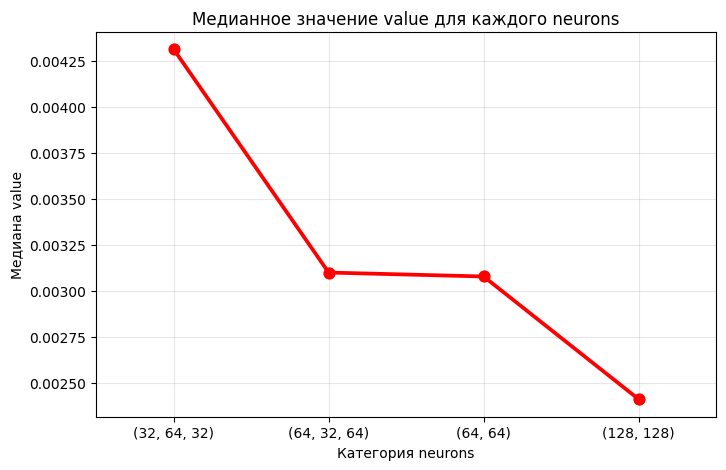

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


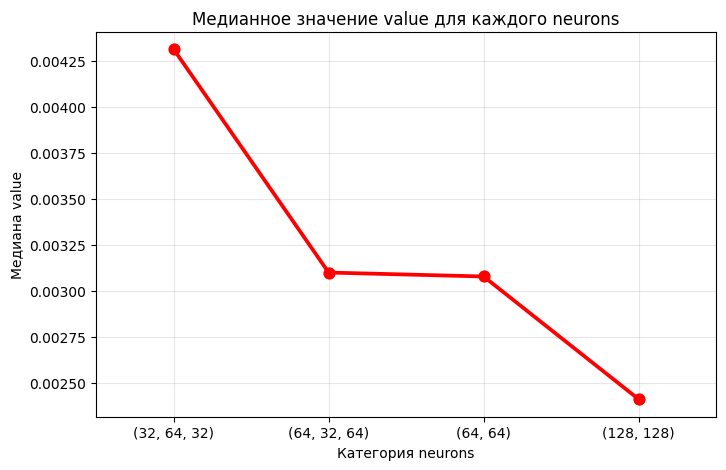

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


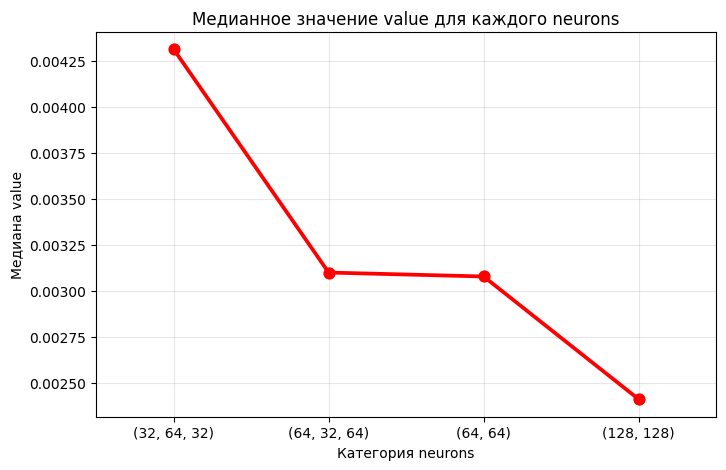

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


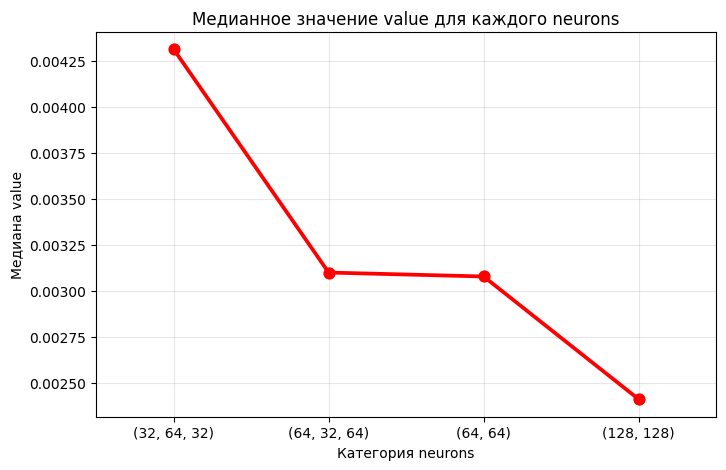

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


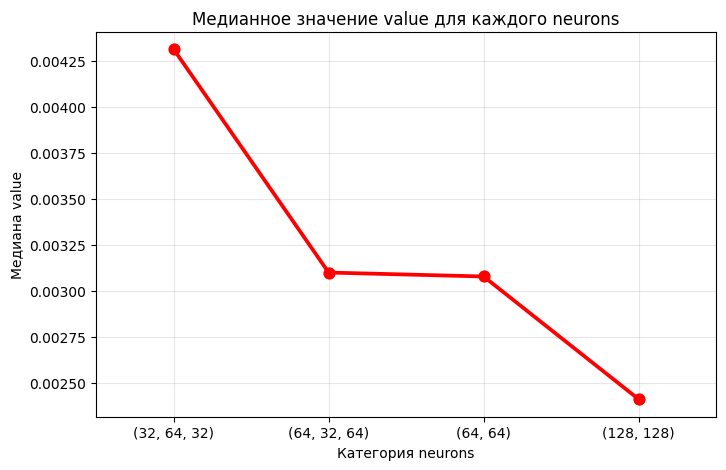

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\1900171401.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=df, x='neurons', y='value', estimator='median',


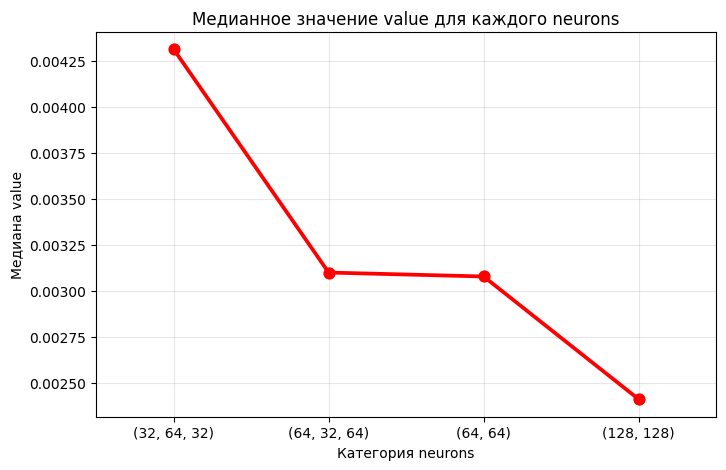

In [16]:

# Фильтрация данных по step = 8000 и конвертация кортежей в строки
df = data[data['step'] == 8000].copy()
df = df[df['tag'] == 'total/loss'].copy()
df["neurons"] = df["neurons"].astype(str)  # Конвертация кортежей в строки

params = ['neurons', 'optimizer', 'scale_quadratic', 'scale_softplus', 'scale_swish', 'scale_tanh']

for param in params:
    plt.figure(figsize=(8, 5))
    sns.pointplot(data=df, x='neurons', y='value', estimator='median', 
                ci=None, color='red', markers='o', linestyles='-')
    plt.title("Медианное значение value для каждого neurons")
    plt.ylabel("Медиана value")
    plt.xlabel("Категория neurons")
    plt.grid(True, alpha=0.3)
    plt.show()

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().res

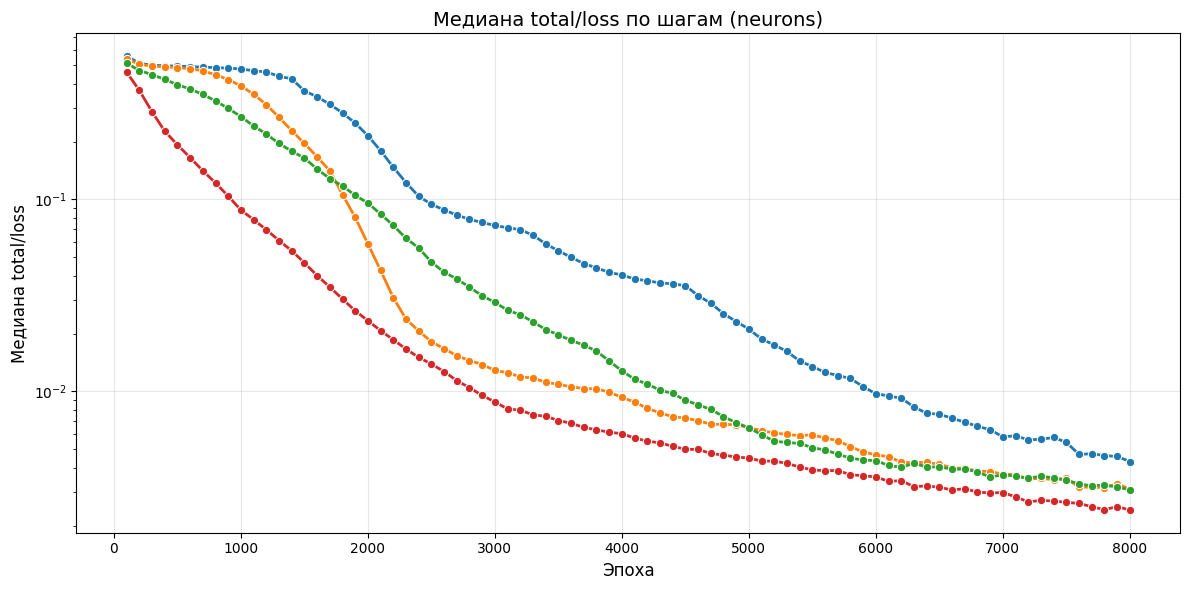

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())


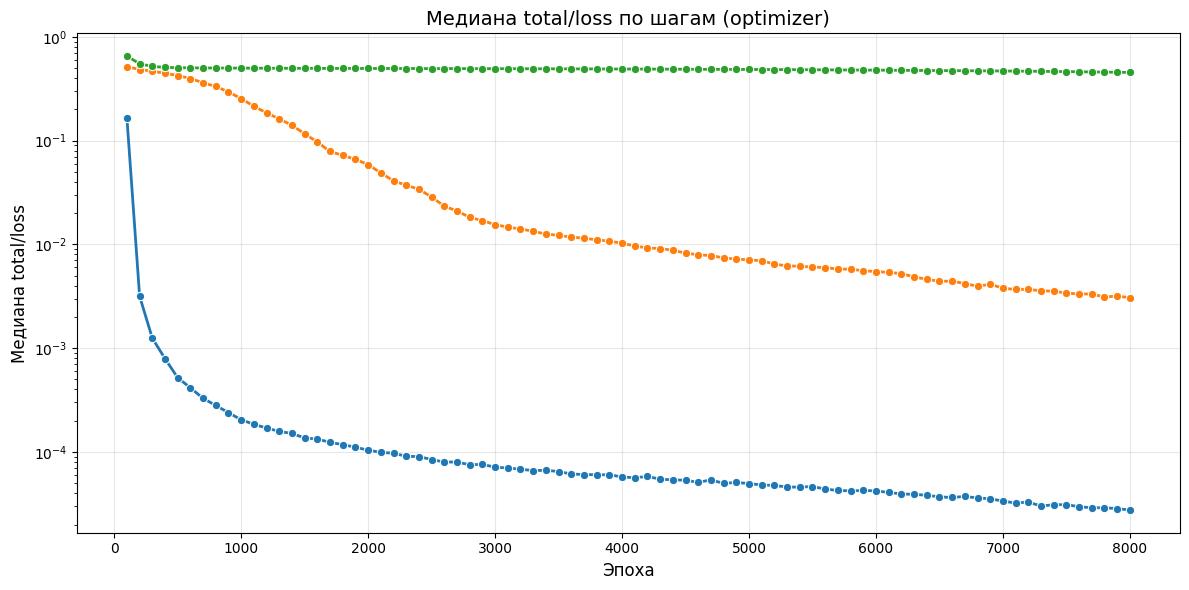

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())


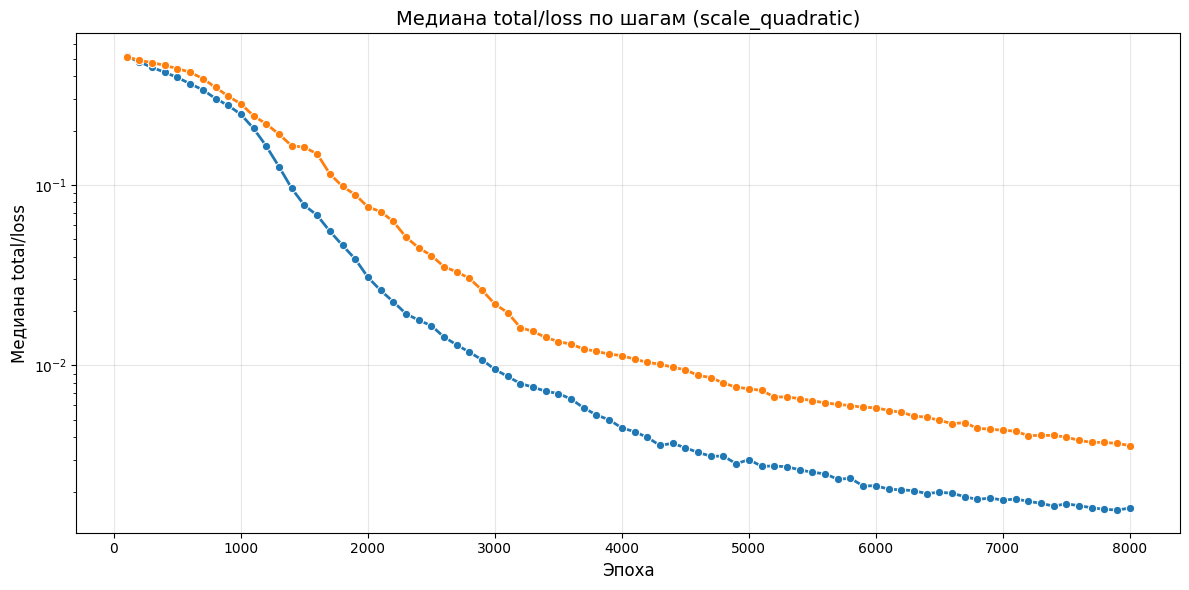

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())


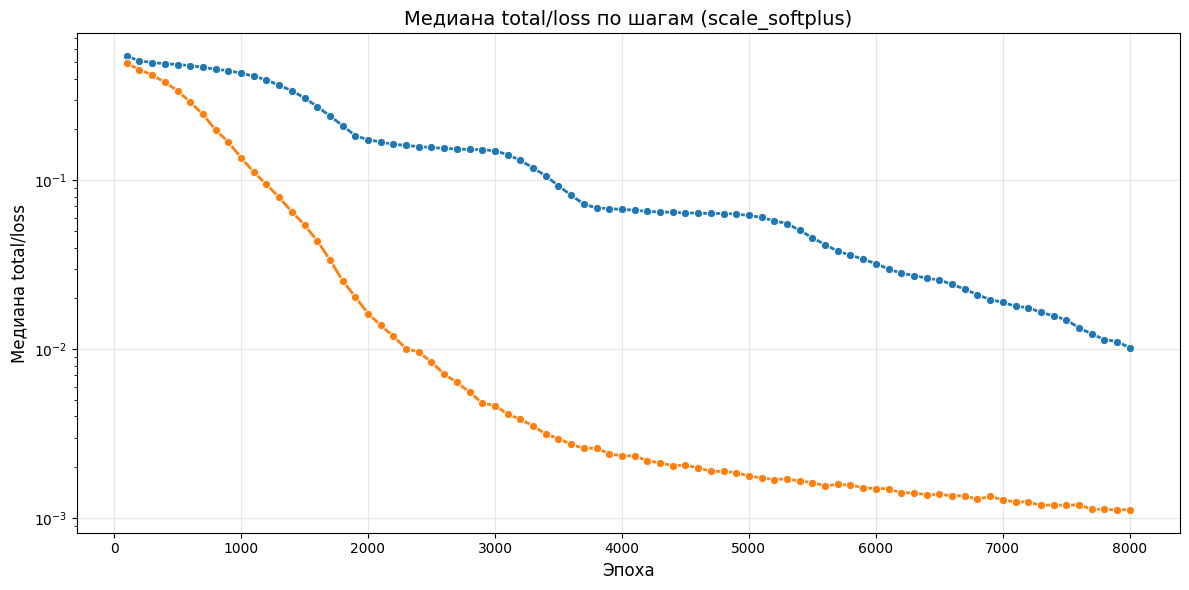

C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
C:\Users\ygrik\AppData\Local\Temp\ipykernel_25312\2966320199.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())


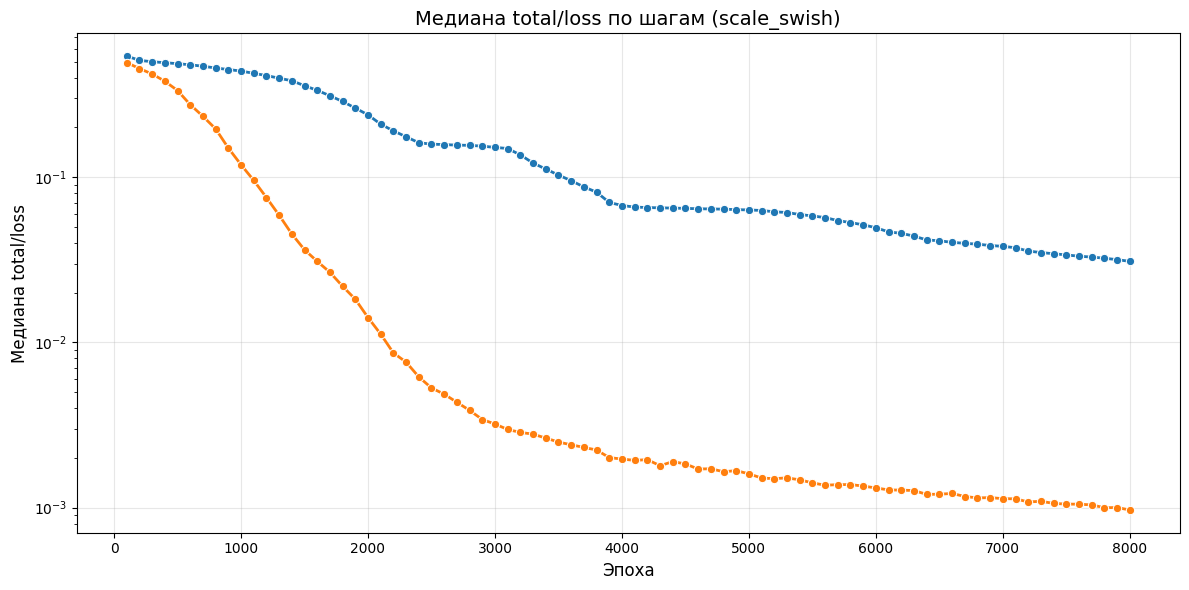

KeyboardInterrupt: 

In [ ]:

def plot_median_by_step(df : pd.DataFrame, param, value_name):
    df_filtered = df[df['step'] % 100 == 0]
    df_median = []
    for unique in df_filtered[param].unique():
        df_median.append(df_filtered[df[param] == unique].groupby(['step', param])['value'].median().reset_index())
    
    plt.figure(figsize=(12, 6))
    for df in df_median:
        sns.lineplot(
            data=df,
            x='step',
            y='value',
            linewidth=2,
            marker='o'
        )
    plt.title(f'Медиана {value_name} по шагам ({param})', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel(f'Медиана {value_name}', fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

value_names = ['total/loss']
for value_name in value_names:
    df_filtered = data[data['tag'] == value_name].copy()
    for param in params:
        plot_median_by_step(df_filtered, param)